# Packages and lib imports

In [46]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# imports

from src.deep.model_analyzer_src import ModelAnalyzer
from src.deep.models import *
from src.deep.trainers import Trainer
from src.general_methods.visualizer import Visualizer

from tqdm.notebook import tqdm
import os


# Parameters configuration

In [48]:
# configs
model_name = 'unet_with_skips_channel2_c_quick_ds_v1'
trained_model_path = '/data/yarcoh/thesis_data/data/test_models/'+model_name
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/b1/1000samples_20mu'
ds_subdir = 'mu=0.38'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# ds_subdir = '100000_samples_mu=0.200'
datasetpath = os.path.join(main_ds_path, ds_subdir)

# Init

In [49]:
# load trainer from file
trainer: Trainer = Trainer.load3(trained_model_path)

In [50]:
conf = trainer.train_dataset.config
conf.__dict__


{'W': 0.05,
 'Nspans': 12,
 'La': 80,
 'M_QAM': 16,
 'Ts': 1.0,
 'Nos': 16,
 'eta': 2,
 'mu': 0.4111111111111111,
 'bet': 0.2,
 'with_ssf': True,
 'with_noise': True,
 'beta2': -21.0,
 'gamma': 1.27,
 'dz': 0.2,
 'K_T': 1.13,
 'chi': 0.0461,
 'verbose': False,
 'io_type': 'c',
 'N_sc': 256,
 'T_guardband': 4750.0880922277665,
 'N_sc_raw': 237.50440461138834,
 'L': 960,
 'T0': 5120.0,
 'Tb': 10240.0,
 'Tn': 1358.1221810508403,
 'Zn': 87833.13612677579,
 'Pn': 8.964743939765935e-06,
 'Ns': 4096,
 'Nnft': 16384,
 'Tnft': 68266.66666666667,
 'dt': 4.166666666666667,
 'Nb': 2458,
 'T1': -25.132741228718345,
 'T2': 25.12967326714258,
 'XI': array([-511.9375,  512.    ])}

In [51]:
# for broken models with old config
from src.optics.config_manager import ConfigManager
trainer.train_dataset.config = ConfigManager.refresh_config(trainer.train_dataset.config)

In [52]:
ma: ModelAnalyzer = ModelAnalyzer(trainer,model_name)

In [53]:
ma.load_test_dataset(datasetpath, train_ds_ratio=0.4, val_ds_ratio=0.3, test_ds_ratio=0.3)

In [54]:
print(len(trainer.val_dataset))

300


In [55]:
#pretty print ds config


# Visualizer.print_config(trainer.val_dataset.config)

# analyze 1 sample

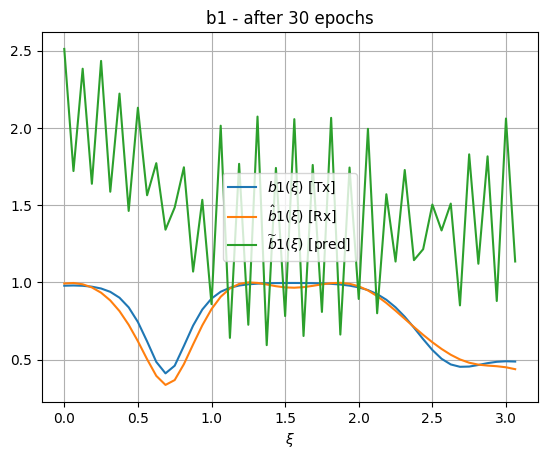

In [56]:
# ma.plot_single_item(1)
N = ma.cs_in.channel_config.Ns
ma.plot_single_item_together(i=1, zm_indices=range(N//2,N//2+50))

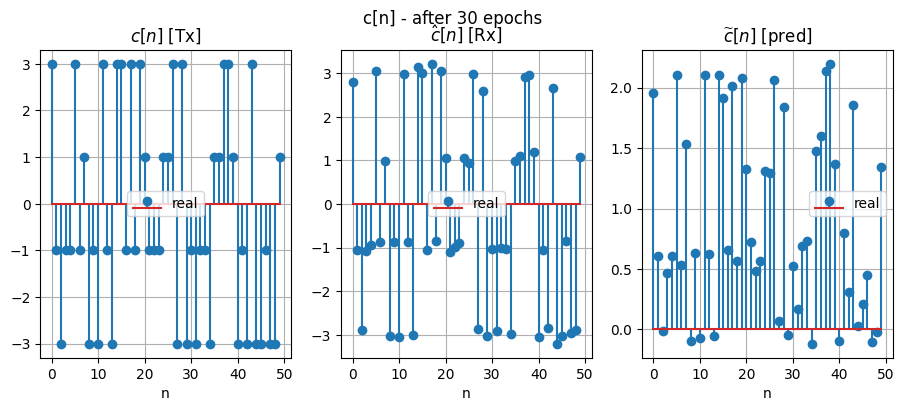

In [57]:
ma.plot_stems(i=1, zm_indices=range(0,50))

# analyze constelation

  0%|          | 0/40 [00:00<?, ?it/s]

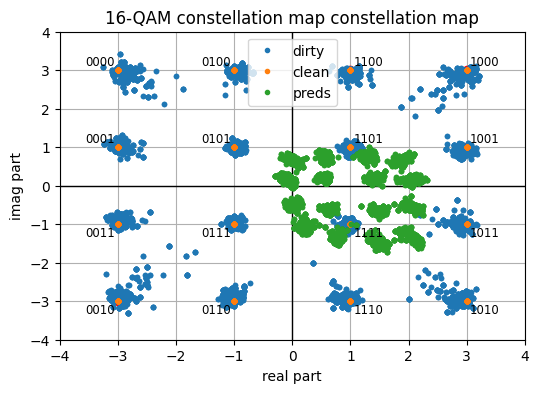

In [58]:
ma.plot_constelation(range(0,40))

In [59]:
x_power_i, y_power, pred_power = ma.calc_norms(_tqdm=tqdm, verbose_level=1, max_items=10000)
print(f'x_power: {x_power_i}\ny_power: {y_power}\npred_power: {pred_power}')

  0%|          | 0/300 [00:00<?, ?it/s]

x_power: 2542.4693009440057
y_power: 2679.1973111979214
pred_power: 11653.072727864555


In [60]:
# ma.upload_single_item_plots_to_wandb(1)

In [61]:
ma.plot_bers(_tqdm=tqdm, verbose_level=1,num_x_per_folder=1000)

  0%|          | 0/300 [00:00<?, ?it/s]

the original avg ber (of validation set) is 0.0016829427083333334


  0%|          | 0/300 [00:00<?, ?it/s]

the trained avg ber (of validation set) is 0.3050618489583333
the ber improvement is -18026.69%


In [ ]:
ma.upload_bers_to_wandb()

# test all BERs

In [ ]:
# add powers

from apps.deep.power_adder import PowerAdder


main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
power_adder = PowerAdder(is_overright=True, verbose_level=2)
power_adder.add_to_all(main_ds_path)
# power_adder.replace_key_in_config_files(main_ds_path)

In [ ]:
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/qam16_50x300/'

ma.plot_all_bers(base_path=main_ds_path, 
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=1, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)
                    

In [ ]:
# print model's architecture
# TODO - make sure every model has this method (make abstract model class that all inherit from)
# trainer.model.print_architecture

# THE END

In [ ]:
# # paper 1 model analyzer
# path_init = '../../data/test_models/mu-0.008__128ds__PaperNNforNFTmodel__3epochs'

# trainer_real = Trainer.load3(path_init + '__real')
# trainer_imag = Trainer.load3(path_init + '__imag')

# train_ds = SingleMuDataSet(trainer_real.train_dataset.data_dir_path,
#                            trainer_real.train_dataset.data_indices)
# val_ds = SingleMuDataSet(trainer_real.val_dataset.data_dir_path,
#                          trainer_real.val_dataset.data_indices)

# model = PaperNNforNFTwrapper(trainer_real.model, trainer_imag.model)

# trainer = Trainer(
#     train_dataset=train_ds,
#     val_dataset=val_ds,
#     model=model,
#     device=trainer_real.device,
#     batch_size=trainer_real.train_dataloader.batch_size,
#     l_metric=trainer_real.l_metric,
#     optim=trainer_real.optim,
#     params=trainer_real.params)

In [ ]:
# analyze on the whole dataset

# attach new dataset to trainer


In [ ]:
trainer.params

In [ ]:
ma = ModelAnalyzer(trainer)

In [ ]:
ma.plot_single_item(i=0)

In [ ]:
ma.plot_bers(_tqdm=tqdm)